# Library

In [ ]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import torch
import torch.nn as nn
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring
from scipy.fftpack import dct
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from google.colab import drive
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path_base = '/content/drive/MyDrive/dataset_full/'
data_folder = 'nonative'
phonics_directories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

phonics_labels = []
file_paths = []
speaker_groups = []

data_path = os.path.join(data_path_base, data_folder)
for region in os.listdir(data_path):
    region_path = os.path.join(data_path, region)
    if os.path.isdir(region_path):
        for phonics in phonics_directories:
            phonics_path = os.path.join(region_path, phonics)
            if os.path.exists(phonics_path):
                for file in os.listdir(phonics_path):
                    if file.endswith('.mp3'):
                        phonics_labels.append(phonics)
                        file_paths.append(os.path.join(phonics_path, file))
                        speaker_groups.append(region)

# Create DataFrame
dataset_df = pd.DataFrame({
    'Phonics': phonics_labels,
    'Speaker_Group': speaker_groups,
    'Path': file_paths})

print(f"Total non-native samples loaded: {len(dataset_df)}")
print(f"Unique phonics in non-native data: {dataset_df['Phonics'].nunique()}")
print("\nPhonics label distribution in non-native data:\n", dataset_df['Phonics'].value_counts().sort_index())
print("\nSpeaker region distribution in non-native data:\n", dataset_df['Speaker_Group'].value_counts())

Total non-native samples loaded: 494
Unique phonics in non-native data: 26

Phonics label distribution in non-native data:
 Phonics
a    19
b    19
c    19
d    19
e    19
f    19
g    19
h    19
i    19
j    19
k    19
l    19
m    19
n    19
o    19
p    19
q    19
r    19
s    19
t    19
u    19
v    19
w    19
x    19
y    19
z    19
Name: count, dtype: int64

Speaker region distribution in non-native data:
 Speaker_Group
jawa      156
papua     104
batam      78
bali       78
madura     78
Name: count, dtype: int64


# Ekstraksi Fitur

In [ ]:
import numpy as np
import torch
import scipy.signal
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

def medium_time_power(signal, M=2):
    padded = np.pad(signal, ((M, M), (0, 0)), mode='constant')
    return np.stack([
        np.mean(padded[i:i + 2 * M + 1], axis=0)
        for i in range(signal.shape[0])
    ])

def asym_lowpass(x, alpha=0.999, beta=0.5):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = np.where(x[i] >= y[i - 1],
                        alpha * y[i - 1] + (1 - alpha) * x[i],
                        beta * y[i - 1] + (1 - beta) * x[i])
    return y

def temporal_masking(x, lam=0.85, mu=0.2):
    peak = np.zeros_like(x)
    masked = np.zeros_like(x)
    peak[0] = x[0]
    masked[0] = x[0]
    for i in range(1, len(x)):
        peak[i] = np.maximum(lam * peak[i - 1], x[i])
        masked[i] = np.where(x[i] >= lam * peak[i - 1], x[i], mu * peak[i - 1])
    return masked

def weight_smoothing(x, ref, N=4):
    smoothed = np.zeros_like(x)
    for t in range(x.shape[0]):
        for f in range(x.shape[1]):
            l1 = max(f - N, 0)
            l2 = min(f + N + 1, x.shape[1])
            smoothed[t, f] = np.mean(x[t, l1:l2] / (ref[t, l1:l2] + 1e-6))
    return smoothed

def extract_pncc(data, sr, n_mels=40, n_fft=512, hop_length=160, win_length=400):
    try:
        data, _ = librosa.effects.trim(data, top_db=40)
        emphasized = scipy.signal.lfilter([1, -0.97], [1], data)

        stft = np.abs(librosa.stft(emphasized, n_fft=n_fft, hop_length=hop_length, win_length=win_length)) ** 2
        mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
        mel_spec = np.dot(mel_basis, stft).T

        mt_power = medium_time_power(mel_spec)
        low_env = asym_lowpass(mt_power)
        subtracted = mt_power - low_env
        rectified = np.maximum(0, subtracted)
        floor = asym_lowpass(rectified)
        masked = temporal_masking(rectified)
        switched = np.where(mt_power >= 2 * low_env, masked, floor)
        smoothed = weight_smoothing(switched, mt_power)
        tf_norm = mel_spec * smoothed

        mean_power = np.zeros(tf_norm.shape[0])
        mean_power[0] = 0.0001
        for i in range(1, tf_norm.shape[0]):
            mean_power[i] = 0.999 * mean_power[i - 1] + 0.001 * np.mean(tf_norm[i])
        norm = tf_norm / (mean_power[:, None] + 1e-6)

        nonlin = norm ** (1 / 15)
        return (nonlin - np.mean(nonlin)) / (np.std(nonlin) + 1e-6)
    except:
        return None

def extract_tensor1d_pncc(data, sr):
    spec = extract_pncc(data, sr)
    if spec is None or np.isnan(spec).any() or np.isinf(spec).any():
        return None
    return torch.tensor(spec, dtype=torch.float32)

In [ ]:
def extract_all_features(dataset_df):
    cnn_data, rnn_data, transformer_data = [], [], []
    for idx, row in dataset_df.iterrows():
        path = row['Path']
        label = row['Phonics']
        try:
            data, sr = librosa.load(path, sr=None, mono=True)
            if len(data) < 1024:
                continue
            variants = [
                data,
                librosa.effects.time_stretch(data, rate=1.1),
                librosa.effects.pitch_shift(data, sr=sr, n_steps=1)
            ]
            for v in variants:
                tensor = extract_tensor1d_pncc(v, sr)
                if tensor is not None and tensor.ndim == 2 and not torch.isnan(tensor).any() and not torch.isinf(tensor).any():
                    cnn_data.append((tensor, str(label)))
                    rnn_data.append((tensor, str(label)))
                    transformer_data.append((tensor, str(label)))
        except:
            continue

    all_labels = [label for _, label in cnn_data + rnn_data + transformer_data]
    if not all_labels:
        return {}

    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)

    def prepare_seq_data(data):
        if not data:
            return np.array([]), np.array([]), np.array([]), np.array([])
        try:
            X, y = zip(*data)
            X = [x.float() if not isinstance(x, torch.FloatTensor) else x for x in X]
            y_encoded = label_encoder.transform(y)
            X_train_list, X_test_list, y_train, y_test = train_test_split(
                list(X), list(y_encoded), test_size=0.2, stratify=y_encoded, random_state=42)
            X_train = pad_sequence(X_train_list, batch_first=True).numpy()
            X_test = pad_sequence(X_test_list, batch_first=True).numpy()
            return X_train, X_test, np.array(y_train), np.array(y_test)
        except:
            return np.array([]), np.array([]), np.array([]), np.array([])

    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = prepare_seq_data(cnn_data)
    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = prepare_seq_data(rnn_data)
    X_train_t, X_test_t, y_train_t, y_test_t = prepare_seq_data(transformer_data)

    return {
        'label_encoder': label_encoder,
        'cnn': (X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn),
        'rnn': (X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn),
        'transformer': (X_train_t, X_test_t, y_train_t, y_test_t)
    }


features = extract_all_features(dataset_df)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = features['cnn']
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = features['rnn']
X_train_t, X_test_t, y_train_t, y_test_t = features['transformer']

In [ ]:
print("CNN Dataset:")
print(f"Train: {X_train_cnn.shape[0]} samples")
print(f"Test : {X_test_cnn.shape[0]} samples\n")

print("RNN Dataset:")
print(f"Train: {X_train_rnn.shape[0]} samples")
print(f"Test : {X_test_rnn.shape[0]} samples\n")

print("Transformer Dataset:")
print(f"Train: {X_train_t.shape[0]} samples")
print(f"Test : {X_test_t.shape[0]} samples")

CNN Dataset:
Train: 1185 samples
Test : 297 samples

RNN Dataset:
Train: 1185 samples
Test : 297 samples

Transformer Dataset:
Train: 1185 samples
Test : 297 samples


# Classifier

## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch.helper import predefined_split
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch import NeuralNetClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\nReducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class CNN_Classifier(nn.Module):
    def __init__(self, input_shape, num_classes, n_blocks, conv_params, dropout, fc_units=256, use_bn=True):
        super().__init__()
        self.blocks = nn.ModuleList()
        in_channels = input_shape[1]

        for i in range(n_blocks):
            out_channels = conv_params[i]['out_channels']
            kernel_size = conv_params[i]['kernel_size']
            pool_size = conv_params[i]['pool_size']
            block_dropout = conv_params[i]['dropout']

            block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                SEBlock(out_channels),
                nn.MaxPool1d(pool_size),
                nn.Dropout(block_dropout)
            )
            self.blocks.append(block)
            in_channels = out_channels

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        classifier_layers = [nn.Linear(in_channels, fc_units)]
        if use_bn:
            classifier_layers.append(nn.BatchNorm1d(fc_units))
        classifier_layers.extend([
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_units, num_classes)
        ])
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)

def objective(trial, X_train, y_train, X_val, y_val, num_classes):
    n_blocks = trial.suggest_int('n_blocks', 2, 4)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    fc_units = trial.suggest_categorical('fc_units', [128, 256, 512])
    use_bn = trial.suggest_categorical('use_bn', [True, False])

    conv_params = []
    for i in range(n_blocks):
        conv_params.append({
            'out_channels': trial.suggest_categorical(f'channels_{i}', [64, 128, 256]),
            'kernel_size': trial.suggest_int(f'kernel_{i}', 3, 7, step=2),
            'pool_size': trial.suggest_int(f'pool_{i}', 1, 2),
            'dropout': trial.suggest_float(f'block_dropout_{i}', 0.1, 0.4)
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=num_classes,
        n_blocks=n_blocks,
        conv_params=conv_params,
        dropout=dropout,
        fc_units=fc_units,
        use_bn=use_bn
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=32, shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=32
    )

    scheduler = CosineAnnealingLR(optimizer, T_max=100)
    best_acc = 0

    for epoch in range(100):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = correct / total
        trial.report(val_acc, epoch)
        if val_acc > best_acc:
            best_acc = val_acc
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_acc

def train_cnn(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val, len(label_encoder.classes_)),
        n_trials=50
    )

    best_params = study.best_trial.params
    print(f"\nBest hyperparameters: {best_params}")

    conv_params = []
    for i in range(best_params['n_blocks']):
        conv_params.append({
            'out_channels': best_params[f'channels_{i}'],
            'kernel_size': best_params[f'kernel_{i}'],
            'pool_size': best_params[f'pool_{i}'],
            'dropout': best_params[f'block_dropout_{i}']
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=len(label_encoder.classes_),
        n_blocks=best_params['n_blocks'],
        conv_params=conv_params,
        dropout=best_params['dropout'],
        fc_units=best_params['fc_units'],
        use_bn=best_params['use_bn']
    ).to(device)

    net = NeuralNetClassifier(
        best_model,
        max_epochs=55,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device=device,
        callbacks=[
            AdaptiveEarlyStopping(patience=5),
            LRScheduler(CosineAnnealingLR, T_max=150),
            EpochScoring('accuracy', name='valid_acc')
        ],
        train_split=predefined_split(
            torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
        )
    )

    net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = net.predict(X_test.astype(np.float32))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    return net

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = features['cnn']
label_encoder = features['label_encoder']
best_model = train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, label_encoder)

[I 2025-06-12 17:31:41,998] A new study created in memory with name: no-name-dfdde768-90b5-47c6-bc18-5f2a9c4c17c3
[I 2025-06-12 17:32:27,447] Trial 0 finished with value: 0.8860759493670886 and parameters: {'n_blocks': 4, 'dropout': 0.3279252936812967, 'fc_units': 256, 'use_bn': True, 'channels_0': 256, 'kernel_0': 7, 'pool_0': 1, 'block_dropout_0': 0.14050137131779597, 'channels_1': 64, 'kernel_1': 7, 'pool_1': 2, 'block_dropout_1': 0.2861008014968768, 'channels_2': 64, 'kernel_2': 5, 'pool_2': 1, 'block_dropout_2': 0.15431904467382315, 'channels_3': 256, 'kernel_3': 3, 'pool_3': 1, 'block_dropout_3': 0.14227583974090066}. Best is trial 0 with value: 0.8860759493670886.
[I 2025-06-12 17:32:52,902] Trial 1 finished with value: 0.8607594936708861 and parameters: {'n_blocks': 2, 'dropout': 0.38070694033368924, 'fc_units': 256, 'use_bn': False, 'channels_0': 128, 'kernel_0': 7, 'pool_0': 1, 'block_dropout_0': 0.3734547304690652, 'channels_1': 64, 'kernel_1': 3, 'pool_1': 1, 'block_dropout


Best hyperparameters: {'n_blocks': 3, 'dropout': 0.25791914370632996, 'fc_units': 128, 'use_bn': True, 'channels_0': 128, 'kernel_0': 7, 'pool_0': 2, 'block_dropout_0': 0.22615072897549587, 'channels_1': 128, 'kernel_1': 5, 'pool_1': 2, 'block_dropout_1': 0.30601632343854906, 'channels_2': 256, 'kernel_2': 3, 'pool_2': 2, 'block_dropout_2': 0.10467350835411462}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        3.1873       0.1350        3.1015  0.0010  0.3410
      2        2.8123       0.2278        2.6306  0.0010  0.3394
      3        2.5009       0.1772        2.9414  0.0010  0.3399
      4        2.3034       0.2025        2.5240  0.0010  0.3429
      5        2.1236       0.3122        2.1354  0.0010  0.3313
      6        1.9898       0.3038        2.1886  0.0010  0.3455
      7        1.8600       0.2574        2.2545  0.0010  0.3408
      8        1.7359       0.3924        1.7653  

Accuracy : 0.8923
Precision: 0.8989
Recall   : 0.8939
F1 Score : 0.8906

Classification Report:
              precision    recall  f1-score   support

           a       0.92      1.00      0.96        11
           b       0.83      0.91      0.87        11
           c       0.75      0.82      0.78        11
           d       0.78      0.64      0.70        11
           e       0.69      1.00      0.81        11
           f       1.00      1.00      1.00        11
           g       0.86      1.00      0.92        12
           h       1.00      1.00      1.00        12
           i       1.00      1.00      1.00        11
           j       0.91      0.91      0.91        11
           k       0.90      0.75      0.82        12
           l       0.91      0.91      0.91        11
           m       0.91      0.91      0.91        11
           n       0.92      1.00      0.96        11
           o       0.91      0.83      0.87        12
           p       0.64      0.82      

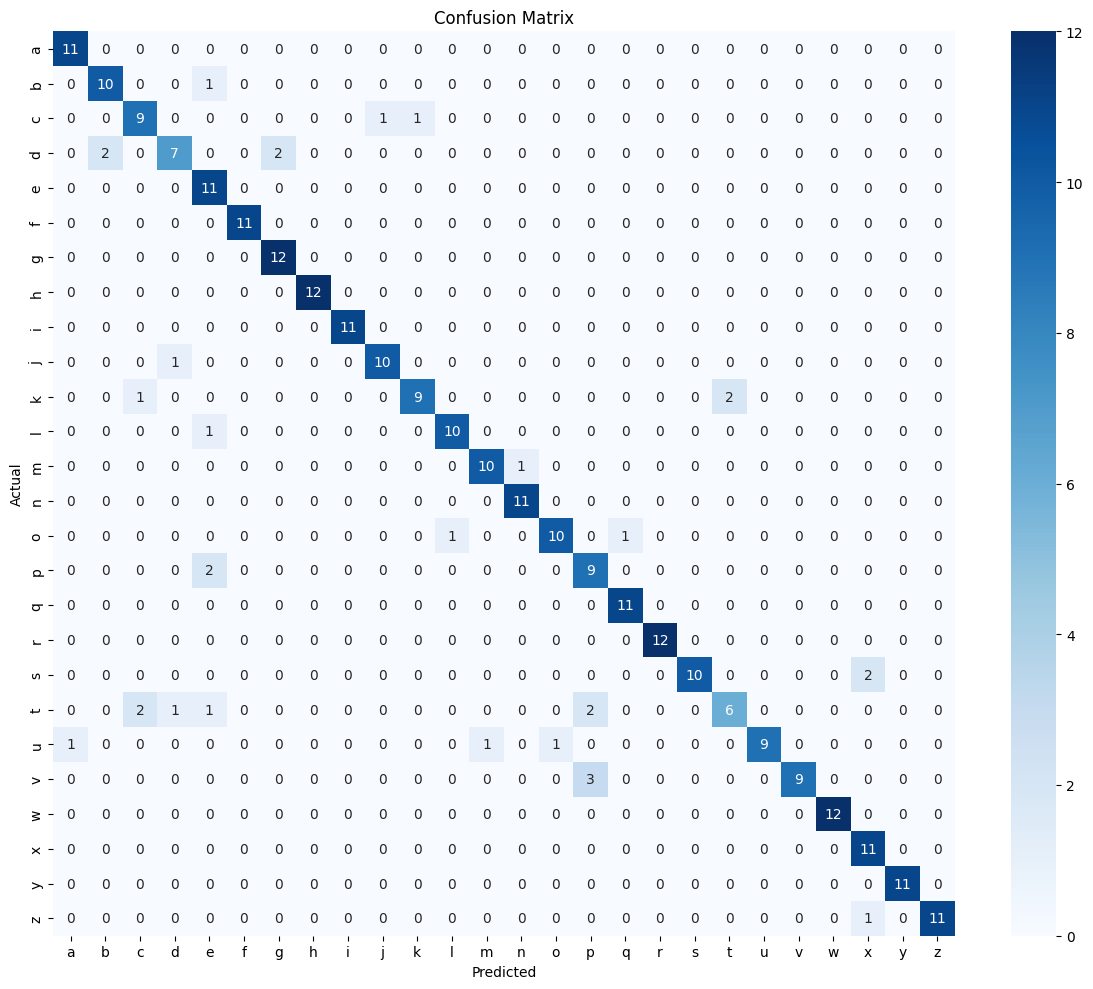

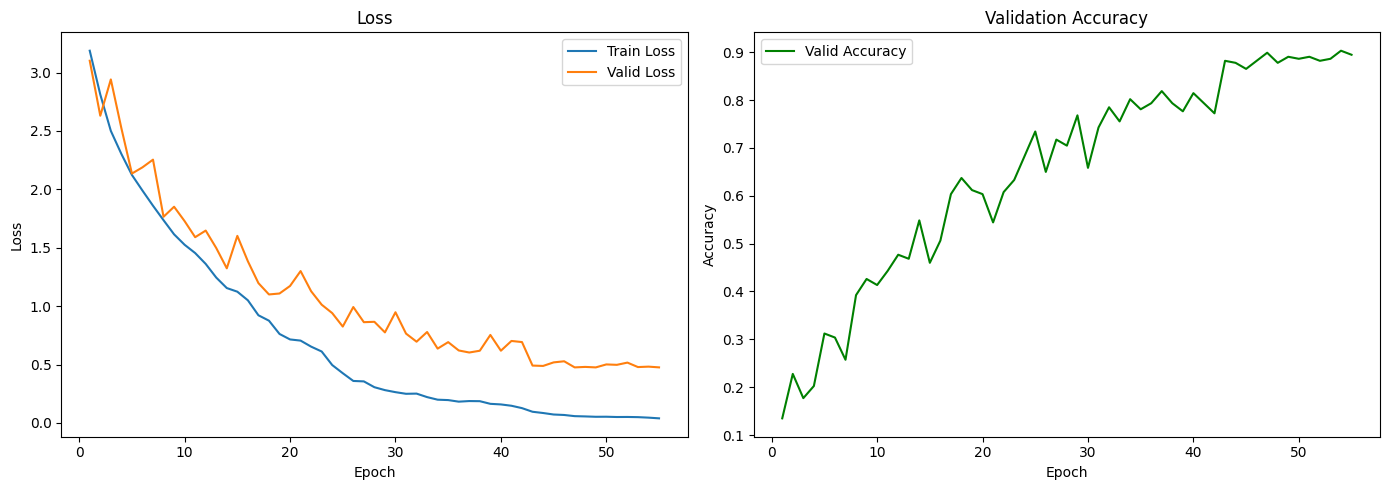

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs+1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs+1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

evaluate_model(best_model, X_test_cnn, y_test_cnn, label_encoder)
plot_training_history(best_model)


## RNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring, Callback
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os, contextlib

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class RNN_GRU(nn.Module):
    def __init__(self, input_dim, num_classes,
                 gru_hidden_size=320, num_layers=2,
                 attention_heads=4, dense_size=512,
                 dropout=0.3, bidirectional=True,
                 activation_fn='mish'):
        super().__init__()

        self.activation = (
            nn.ReLU() if activation_fn == 'relu'
            else nn.GELU() if activation_fn == 'gelu'
            else nn.Mish()
        )

        self.gru = nn.GRU(
            input_dim,
            gru_hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=gru_hidden_size * (2 if bidirectional else 1),
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(gru_hidden_size * (2 if bidirectional else 1), dense_size),
            self.activation,
            nn.LayerNorm(dense_size),
            nn.Dropout(dropout),
            nn.Linear(dense_size, num_classes)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attn_out, _ = self.attention(gru_out, gru_out, gru_out)
        pooled = attn_out.mean(dim=1)
        return self.classifier(pooled)

def gru_optuna(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    X_train_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_train]
    X_val_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_val]
    X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_test]

    X_train_pad = pad_sequence(X_train_tensor, batch_first=True).numpy()
    X_val_pad = pad_sequence(X_val_tensor, batch_first=True).numpy()
    X_test_pad = pad_sequence(X_test_tensor, batch_first=True).numpy()

    def objective(trial):
        input_dim = X_train_pad.shape[-1]
        num_classes = len(label_encoder.classes_)

        model = RNN_GRU(
            input_dim=input_dim,
            num_classes=num_classes,
            gru_hidden_size=trial.suggest_categorical('gru_hidden_size', [256, 320, 384]),
            num_layers=trial.suggest_int('num_layers', 1, 3),
            attention_heads=trial.suggest_categorical('attention_heads', [2, 4, 8]),
            dense_size=trial.suggest_categorical('dense_size', [384, 512, 640]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            bidirectional=trial.suggest_categorical('bidirectional', [True, False]),
            activation_fn=trial.suggest_categorical('activation_fn', ['relu', 'gelu', 'mish'])
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(
                torch.utils.data.TensorDataset(
                    torch.FloatTensor(X_val_pad),
                    torch.LongTensor(y_val)
                )
            ),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_params)

    best_params = study.best_params
    input_dim = X_train_pad.shape[-1]
    num_classes = len(label_encoder.classes_)

    final_model = RNN_GRU(
        input_dim=input_dim,
        num_classes=num_classes,
        gru_hidden_size=best_params['gru_hidden_size'],
        num_layers=best_params['num_layers'],
        attention_heads=best_params['attention_heads'],
        dense_size=best_params['dense_size'],
        dropout=best_params['dropout'],
        bidirectional=best_params['bidirectional'],
        activation_fn=best_params['activation_fn']
    )

    final_net = NeuralNetClassifier(
        final_model,
        max_epochs=50,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(
            torch.utils.data.TensorDataset(
                torch.FloatTensor(X_val_pad),
                torch.LongTensor(y_val)
            )
        ),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))
    y_pred = final_net.predict(X_test_pad.astype(np.float32))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return final_net

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = features['rnn']
label_encoder = features['label_encoder']
best_gru_model = gru_optuna(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, label_encoder)

[I 2025-06-12 17:41:20,022] A new study created in memory with name: no-name-6cb56c34-2b30-4c41-8dcf-15a939faaf73


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-12 17:43:24,064] Trial 0 finished with value: 0.9113924050632911 and parameters: {'gru_hidden_size': 256, 'num_layers': 1, 'attention_heads': 8, 'dense_size': 640, 'dropout': 0.30000000000000004, 'bidirectional': False, 'activation_fn': 'mish'}. Best is trial 0 with value: 0.9113924050632911.
[I 2025-06-12 17:46:25,010] Trial 1 finished with value: 0.9240506329113924 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 2, 'dense_size': 640, 'dropout': 0.4, 'bidirectional': True, 'activation_fn': 'mish'}. Best is trial 1 with value: 0.9240506329113924.
[I 2025-06-12 17:49:53,432] Trial 2 finished with value: 0.9282700421940928 and parameters: {'gru_hidden_size': 384, 'num_layers': 3, 'attention_heads': 8, 'dense_size': 512, 'dropout': 0.30000000000000004, 'bidirectional': False, 'activation_fn': 'mish'}. Best is trial 2 with value: 0.9282700421940928.
[I 2025-06-12 17:53:21,451] Trial 3 finished with value: 0.9029535864978903 and parameters: {'gru_hidd

Accuracy : 0.9293
Precision: 0.9389
Recall   : 0.9301
F1 Score : 0.9305

Classification Report:
              precision    recall  f1-score   support

           a       0.91      0.91      0.91        11
           b       1.00      0.82      0.90        11
           c       1.00      1.00      1.00        11
           d       0.83      0.91      0.87        11
           e       1.00      1.00      1.00        11
           f       1.00      0.82      0.90        11
           g       0.79      0.92      0.85        12
           h       0.86      1.00      0.92        12
           i       1.00      1.00      1.00        11
           j       1.00      0.91      0.95        11
           k       1.00      0.83      0.91        12
           l       1.00      1.00      1.00        11
           m       0.85      1.00      0.92        11
           n       1.00      0.91      0.95        11
           o       1.00      1.00      1.00        12
           p       0.67      0.91      

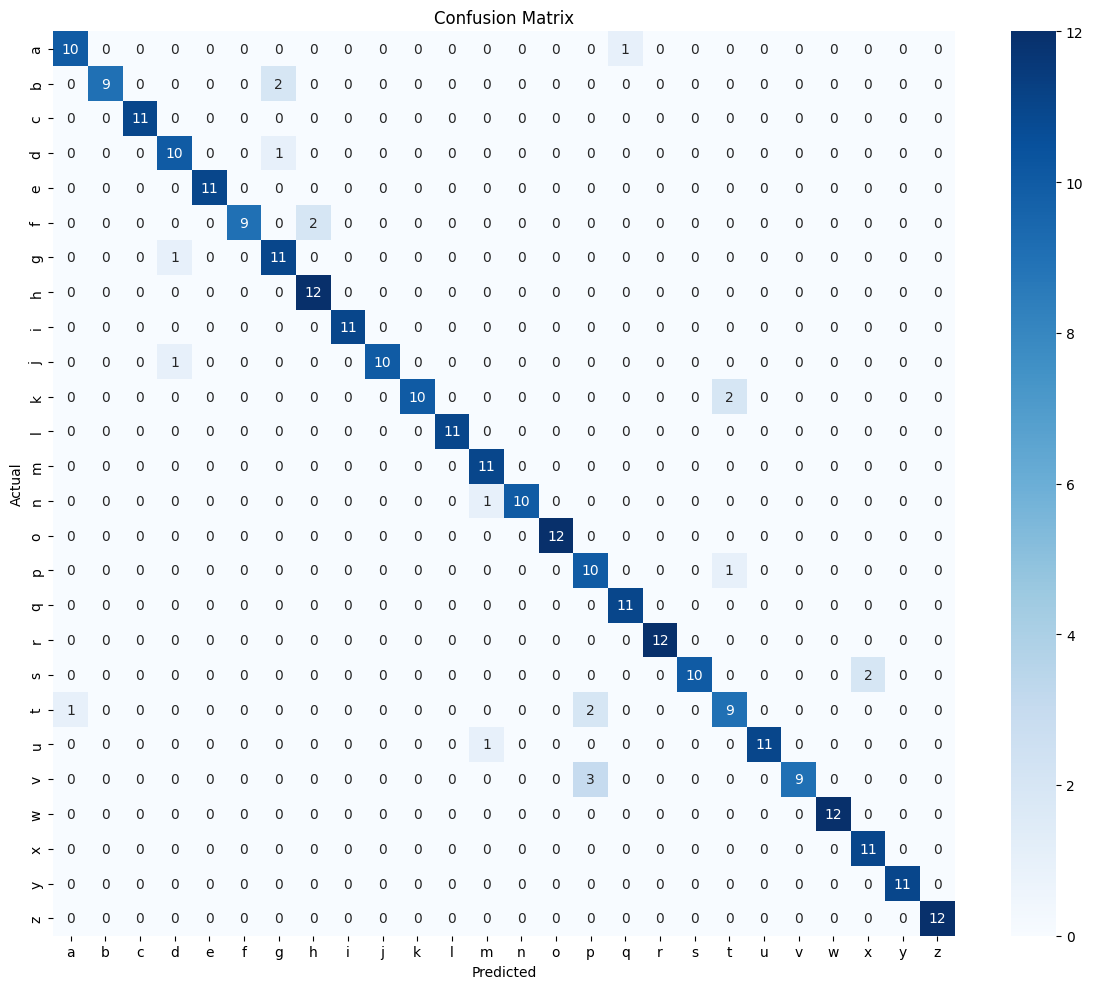

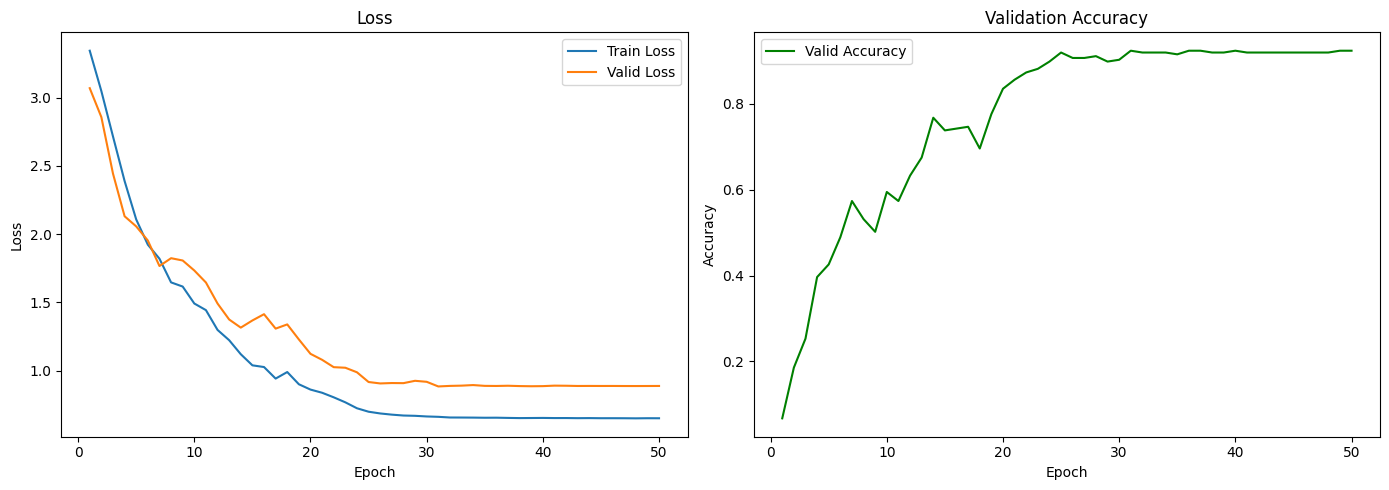

In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs + 1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs + 1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


evaluate_model(best_gru_model, X_test_rnn, y_test_rnn, label_encoder)
plot_training_history(best_gru_model)

## Transformer

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import optuna
import math
import os
import contextlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch.helper import predefined_split

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.max_len = max_len
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.max_len:
            raise ValueError(f"Input sequence length {seq_len} exceeds maximum {self.max_len}")
        return x + self.pe[:seq_len, :]

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, nhead, d_model, dim_feedforward, dropout, dense, activation, max_len):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dense),
            nn.ReLU(),
            nn.LayerNorm(dense),
            nn.Dropout(dropout),
            nn.Linear(dense, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

def train_transformer(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    max_seq_len = X_train.shape[1]

    def objective(trial):
        d_model = trial.suggest_categorical('d_model', [64, 128, 256])
        valid_heads = [h for h in [2, 4, 8] if d_model % h == 0]
        if not valid_heads:
            raise optuna.exceptions.TrialPruned()

        model = TransformerClassifier(
            input_dim=X_train.shape[-1],
            num_classes=len(label_encoder.classes_),
            num_layers=trial.suggest_int('num_layers', 2, 4),
            nhead=trial.suggest_categorical('nhead', valid_heads),
            d_model=d_model,
            dim_feedforward=trial.suggest_categorical('dim_feedforward', [256, 512, 1024]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            dense=trial.suggest_categorical('dense', [128, 256, 512]),
            activation=trial.suggest_categorical('activation', ['relu', 'gelu']),
            max_len=max_seq_len
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_trial.params)

    best_params = study.best_trial.params
    model = TransformerClassifier(
        input_dim=X_train.shape[-1],
        num_classes=len(label_encoder.classes_),
        **best_params,
        max_len=max_seq_len
    )

    final_net = NeuralNetClassifier(
        model,
        max_epochs=50,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = final_net.predict(X_test.astype(np.float32))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return final_net, X_test, y_test, label_encoder

X_train_t, X_test_t, y_train_t, y_test_t = features['transformer']
label_encoder = features['label_encoder']
best_transformer = train_transformer(X_train_t, y_train_t, X_test_t, y_test_t, label_encoder)

[I 2025-06-12 19:19:50,159] A new study created in memory with name: no-name-810aff10-262b-456a-960d-56e7caa62167


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-12 19:21:25,712] Trial 0 finished with value: 0.20253164556962025 and parameters: {'d_model': 256, 'num_layers': 3, 'nhead': 2, 'dim_feedforward': 256, 'dropout': 0.35000000000000003, 'dense': 512, 'activation': 'relu'}. Best is trial 0 with value: 0.20253164556962025.
[I 2025-06-12 19:22:34,605] Trial 1 finished with value: 0.759493670886076 and parameters: {'d_model': 256, 'num_layers': 2, 'nhead': 4, 'dim_feedforward': 256, 'dropout': 0.25, 'dense': 128, 'activation': 'relu'}. Best is trial 1 with value: 0.759493670886076.
[I 2025-06-12 19:23:28,473] Trial 2 finished with value: 0.729957805907173 and parameters: {'d_model': 64, 'num_layers': 3, 'nhead': 2, 'dim_feedforward': 1024, 'dropout': 0.30000000000000004, 'dense': 256, 'activation': 'relu'}. Best is trial 1 with value: 0.759493670886076.
[I 2025-06-12 19:25:12,790] Trial 3 finished with value: 0.8270042194092827 and parameters: {'d_model': 256, 'num_layers': 2, 'nhead': 8, 'dim_feedforward': 1024, 'dropout': 0.3000


Accuracy : 0.8519
Precision: 0.8714
Recall   : 0.8537
F1 Score : 0.8555

Classification Report:
              precision    recall  f1-score   support

           a       0.69      1.00      0.81        11
           b       0.50      0.64      0.56        11
           c       0.85      1.00      0.92        11
           d       0.69      0.82      0.75        11
           e       1.00      0.82      0.90        11
           f       0.90      0.82      0.86        11
           g       0.90      0.75      0.82        12
           h       0.69      0.75      0.72        12
           i       0.91      0.91      0.91        11
           j       1.00      0.91      0.95        11
           k       1.00      0.83      0.91        12
           l       0.85      1.00      0.92        11
           m       0.91      0.91      0.91        11
           n       0.91      0.91      0.91        11
           o       1.00      0.83      0.91        12
           p       0.82      0.82     

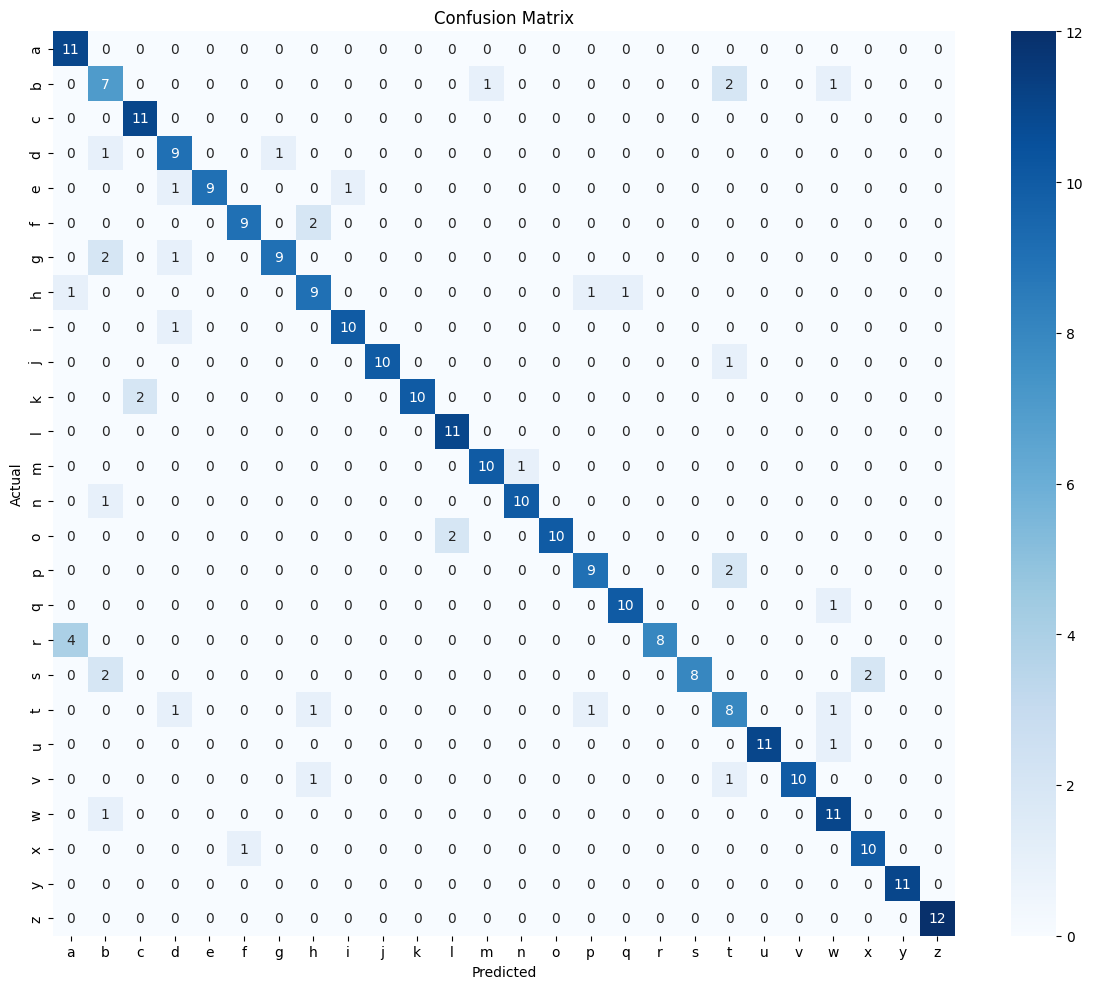

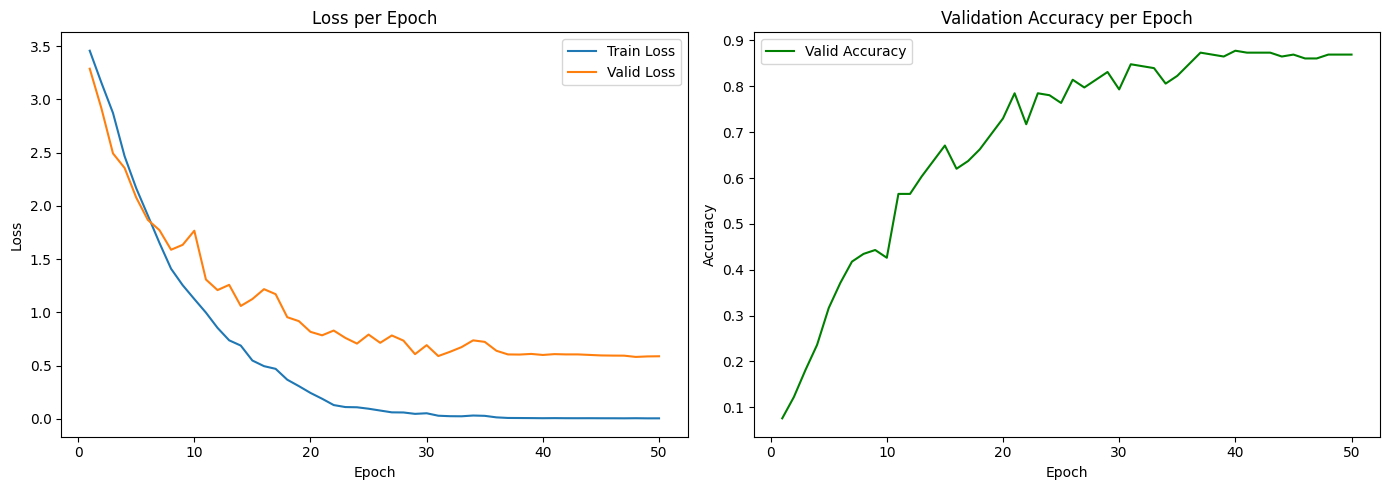

In [ ]:
def evaluate_model(model_tuple):
    model, X_test, y_test, label_encoder = model_tuple
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    valid_loss = history[:, 'valid_loss']
    valid_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs + 1), valid_loss, label='Valid Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs + 1), valid_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy per Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

evaluate_model(best_transformer)
plot_training_history(best_transformer[0])